In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [25]:
!pip install mediapipe


### Importing all the necessary libraries

In [26]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc


### Loading the dataset

In [27]:
data = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
print("Full train dataset shape is {}".format(data.shape))

Full train dataset shape is (67208, 5)


In [5]:
data.head()

path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   

                      phrase  
0               3 creekhouse  
1            scales/kuhaylah  
2        1383 william lanier  
3          988 franklin lane  
4  6920 northeast 661st road

### Now let us understand the dataset and how all the files are linked to each other

### Train.csv has an entry for every phrase along with its sequence_id, path, and file_id. The sequence_id is the unique index of the landmark sequence within the landmarks data file, and file_id specifies the file containing the landmarks data for that specific phrase.

### The diagram that follows provides an illustration of how files are related.

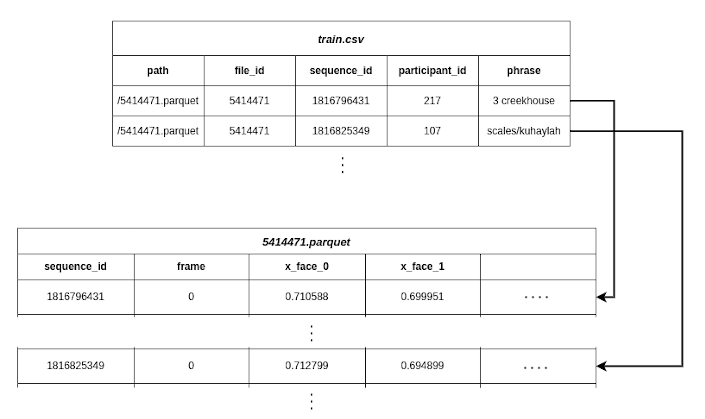


### Now we will examine one example row from landmark file and how it is related with train.csv

In [28]:
# Fetch sequence_id, file_id, phrase from 7th row
sequence_id, file_id, phrase = data.iloc[6][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

sequence_id: 1817169529, file_id: 5414471, phrase: https://jsi.is/hukuoka


### Now next we can access the parquet file for particular sequence id in the following manner 

In [29]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))

Full sequence dataset shape is (300, 1630)


In [30]:
# Now let us this sample_sequence_df 
sample_sequence_df.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1817169529       0  0.740435  0.734038  0.737507  0.723142  0.733195   
1817169529       1  0.743968  0.731306  0.734982  0.720691  0.730481   
1817169529       2  0.735330  0.727608  0.731663  0.717006  0.726665   
1817169529       3  0.741500  0.724301  0.728569  0.714643  0.723468   
1817169529       4  0.738992  0.729264  0.733287  0.718563  0.728307   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1817169529   0.733479  0.735043  0.653469  0.734492  ...        -0.327317   
1817169529   0.730834  0.732612  0.651775  0.732095  ...        -0.280167   
1817169529   0.727005  0.728827  0.648945  0.728236  ...        -0.262822   
1817169529   0.724143  0.726969  0.648704  0.726976  ...        -0.164224   
1817169529   0.728631  0.730391  0.650175  0.729882  ...        -0.161075   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1817169529         -0.358946        -0.205048        -0.289102   
1817169529         -0.301074        -0.174787        -0.245952   
1817169529         -0.280881        -0.170362        -0.222043   
1817169529         -0.172994        -0.124070        -0.154734   
1817169529         -0.168983        -0.120189        -0.148746   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1817169529         -0.316426        -0.330475        -0.224326   
1817169529         -0.250015        -0.244606        -0.193371   
1817169529         -0.208816        -0.195668        -0.187259   
1817169529         -0.138793        -0.125200        -0.137634   
1817169529         -0.126287        -0.107934        -0.134492   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1817169529         -0.283333        -0.297210        -0.305664  
1817169529         -0.238736        -0.233796        -0.225342  
1817169529         -0.210144        -0.189974        -0.174090  
1817169529         -0.151121        -0.132724        -0.118861  
1817169529         -0.145703        -0.122515        -0.104440  

[5 rows x 1630 columns]

In [31]:
# Now let us this sample_sequence_df 
sample_sequence_df.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1817169529       0  0.740435  0.734038  0.737507  0.723142  0.733195   
1817169529       1  0.743968  0.731306  0.734982  0.720691  0.730481   
1817169529       2  0.735330  0.727608  0.731663  0.717006  0.726665   
1817169529       3  0.741500  0.724301  0.728569  0.714643  0.723468   
1817169529       4  0.738992  0.729264  0.733287  0.718563  0.728307   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1817169529   0.733479  0.735043  0.653469  0.734492  ...        -0.327317   
1817169529   0.730834  0.732612  0.651775  0.732095  ...        -0.280167   
1817169529   0.727005  0.728827  0.648945  0.728236  ...        -0.262822   
1817169529   0.724143  0.726969  0.648704  0.726976  ...        -0.164224   
1817169529   0.728631  0.730391  0.650175  0.729882  ...        -0.161075   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1817169529         -0.358946        -0.205048        -0.289102   
1817169529         -0.301074        -0.174787        -0.245952   
1817169529         -0.280881        -0.170362        -0.222043   
1817169529         -0.172994        -0.124070        -0.154734   
1817169529         -0.168983        -0.120189        -0.148746   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1817169529         -0.316426        -0.330475        -0.224326   
1817169529         -0.250015        -0.244606        -0.193371   
1817169529         -0.208816        -0.195668        -0.187259   
1817169529         -0.138793        -0.125200        -0.137634   
1817169529         -0.126287        -0.107934        -0.134492   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1817169529         -0.283333        -0.297210        -0.305664  
1817169529         -0.238736        -0.233796        -0.225342  
1817169529         -0.210144        -0.189974        -0.174090  
1817169529         -0.151121        -0.132724        -0.118861  
1817169529         -0.145703        -0.122515        -0.104440  

[5 rows x 1630 columns]

### Visualizing data with mediapipe APIs
### Let's utilize the hand landmarker apis of the mediapipe library to visualize the hand landmarks data for the phrase 3 Creek House.

### The main digits on a human hand are represented by hand landmarks.

In [32]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc

# Set matplotlib parameters
plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_image_animation(image_list):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 9))
    ax.set_axis_off()

    # Display the first image
    im = ax.imshow(image_list[0], cmap="gray")
    plt.close(fig)

    # Define the animation function
    def animate_frame(frame_idx):
        im.set_array(image_list[frame_idx])
        return [im]

    # Create and return the animation
    animation_obj = animation.FuncAnimation(fig, animate_frame, frames=len(image_list), interval=1000/10)
    return animation_obj


### Now we will be Extracting the landmark data and use the Medipipe library to turn it into a picture. The data is extracted for both hands by this function

In [33]:
import mediapipe
import numpy as np
from mediapipe.framework.formats import landmark_pb2

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils
mp_drawing_styles = mediapipe.solutions.drawing_styles

def extract_hand_landmarks(sequence_df):
    hand_images = []
    all_hand_landmarks = []

    for seq_idx in range(len(sequence_df)):
        right_x = sequence_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        right_y = sequence_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        right_z = sequence_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))
        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()

        for x, y, z in zip(right_x, right_y, right_z):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
            right_hand_image,
            right_hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
        )

        left_x = sequence_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        left_y = sequence_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        left_z = sequence_df.iloc[seq_idx].filter(regex="z_left_hand.*").values

        left_hand_image = np.zeros((600, 600, 3))
        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()

        for x, y, z in zip(left_x, left_y, left_z):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
            left_hand_image,
            left_hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
        )

        hand_images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])

    return hand_images, all_hand_landmarks


In [34]:
# Extract hand images and landmarks using mediapipe APIs
extracted_images, extracted_landmarks = extract_hand_landmarks(sample_sequence_df)

# Fetch and display the data for the right hand using animation
right_hand_images = np.array(extracted_images)[:, 0]
create_image_animation(right_hand_images)


### Preprocesss the data
We will reorganize the data to include the landmark data and the phrase it represents in each parquet file for efficiency and ease. In this manner, we may avoid alternating between the train.csv and its parquet file.

The updated information will be stored in TFRecord format. A straightforward format for storing a series of binary records is called TFRecord. Using TFRecord to store and load the data is significantly faster and more efficient.

### References 
https://www.kaggle.com/code/irohith/aslfr-preprocess-dataset

https://www.kaggle.com/code/shlomoron/aslfr-parquets-to-tfrecords-cleaned

### Now The primary emphasis of ASL Finger spelling is hand movement. In order to train the model, we will use hand land mark coordinates and hand pose coordinates.


### Now Fetching the pose landmark coordinates related to hand movement.

In [36]:
# Define pose coordinates for hand movement
LEFT_HAND_POSE = [13, 15, 17, 19, 21]
RIGHT_HAND_POSE = [14, 16, 18, 20, 22]
FULL_HAND_POSE = LEFT_HAND_POSE + RIGHT_HAND_POSE


### Creating x,y,z label names from coordinates¶


In [37]:
# Define lists for X, Y, and Z coordinates for hands and pose
X_HAND_RIGHT = [f'x_right_hand_{i}' for i in range(21)]
Y_HAND_RIGHT = [f'y_right_hand_{i}' for i in range(21)]
Z_HAND_RIGHT = [f'z_right_hand_{i}' for i in range(21)]

X_HAND_LEFT = [f'x_left_hand_{i}' for i in range(21)]
Y_HAND_LEFT = [f'y_left_hand_{i}' for i in range(21)]
Z_HAND_LEFT = [f'z_left_hand_{i}' for i in range(21)]

X_POSE = [f'x_pose_{i}' for i in FULL_HAND_POSE]
Y_POSE = [f'y_pose_{i}' for i in FULL_HAND_POSE]
Z_POSE = [f'z_pose_{i}' for i in FULL_HAND_POSE]

# Combine all coordinate lists
X = X_HAND_RIGHT + X_HAND_LEFT + X_POSE
Y = Y_HAND_RIGHT + Y_HAND_LEFT + Y_POSE
Z = Z_HAND_RIGHT + Z_HAND_LEFT + Z_POSE


### Creating the feature columns from the extracted coordinates.



In [39]:
FEATURE_COLUMNS = X + Y + Z


### Storing ids of each coordinate labels to lists



In [40]:
# Identify indices for X, Y, and Z coordinates in FEATURE_COLUMNS
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "z_" in col]

# Identify indices for right and left hand features in FEATURE_COLUMNS
RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "left" in col]

# Identify indices for right and left pose features in FEATURE_COLUMNS based on RPOSE and LPOSE
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "pose" in col and int(col.split("_")[-1]) in RIGHT_HAND_POSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "pose" in col and int(col.split("_")[-1]) in LEFT_HAND_POSE]


### Now we will be Prepare the dataset and write it as TFRecords.
Let's generate new dataset files and write them as TFRecords using the extracted landmarks and phrases.

It takes about ten minutes to complete. Any further experiments will load the dataset more quickly after this.

In [41]:
import os
import shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from tqdm import tqdm

# Set length of frames to 128
FRAME_LEN = 128

# Create a directory to store the new data
output_directory = "preprocessed"
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)

# Loop through each file_id
for file_id in tqdm(data.file_id.unique()):
    # Parquet file name
    pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = data.loc[data["file_id"] == file_id]
    
    # Fetch the parquet file
    parquet_df = pq.read_table(pq_file, columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    
    # File name for the updated data
    tf_file = f"{output_directory}/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    
    # Initialize the pointer to write the output of each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in the file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis=1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis=1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2 * len(phrase) < no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)


100%|██████████| 68/68 [09:46<00:00,  8.63s/it]
